In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_data, get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim

## Choose Devices

In [2]:
gpu_id = 0
num_cores = 4

In [3]:
torch.cuda.set_device(gpu_id)

To load the patch critic, loading data is necessary. Is there a way to load the model without loading any data (can we save a good critic not as .pth file but as something else)?

# Feature loss

## Gram loss

In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

## Base loss

In [5]:
base_loss = F.l1_loss

## Resnet Feature loss

### Define the feature loss class

In [6]:
def next_ind(cur_ind, i):
        ind = cur_ind.copy()
        ind.append(i)
        return ind

def pooling_layer(block, cur_ind=[]):
    """cur_ind: the index of Sequential or BasicBlock that the code is looking into"""
    returned_block = []
    returned_index = []

    for i, k in enumerate(block):
        if isinstance(k, (torch.nn.modules.container.Sequential, torchvision.models.resnet.BasicBlock)):
            new_block, new_index = pooling_layer(k.children(), next_ind(cur_ind, i))
            returned_block.extend(new_block)
            returned_index.extend(new_index)
        elif isinstance(k, torch.nn.modules.conv.Conv2d) and k.stride==(2,2):
            returned_block.append(k)
            returned_index.append(next_ind(cur_ind, i))
    return returned_block, returned_index

def previous_layer(layer_ind):
    prev_layer_list = []
    for ind in layer_ind:
        if not sum(ind):
            continue
        prev_layer = ind.copy()
        prev_layer[-1] -= 1
        if prev_layer[-1] == -1:
            for i in list(range(len(prev_layer)))[::-1]:
                if prev_layer[i] == -1:
                    prev_layer[i-1] -= 1
        prev_layer_list.append(prev_layer)
    return prev_layer_list

In [16]:
encoder = models.resnet34(True).eval().cuda()
requires_grad(encoder, False)
layers, layer_ind = pooling_layer(list(encoder.children()))
act_blocks = previous_layer(layer_ind)
layers, act_blocks

([Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
  Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False),
  Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
  Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)],
 [[4, -1, -1],
  [5, 0, 4, -1],
  [5, -1, -1],
  [6, 0, 4, -1],
  [6, -1, -1],
  [7, 0, 4, -1]])

In [17]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = self.make_layers(layer_ids)
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_layers(self, layer_ids):
        loss_features = []
        for layer in layer_ids:
            obj = self.m_feat
            for i in layer:
                try:
                    obj = obj[i]
                except TypeError:
                    children = list(obj.children())
                    if len(children):
                        obj = children[i]
                    else:
                        break
            loss_features.append(obj)
        return loss_features
    
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [18]:
feat_loss = FeatureLoss(m_feat=encoder, layer_ids=act_blocks, layer_wgts=[1/6 for _ in range(6)])

# Model

## Initialization

In [19]:
nb_name = 'featureloss-resnet34-pretrained-imagenet'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_path = data_pth/f'EM/models/feat_loss/'

# helper func
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)

In [20]:
superres_metrics = [F.mse_loss, psnr, ssim]

In [21]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(db, arch, wd=wd, 
                         loss_func=feat_loss,
#                          loss_func=F.mse_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
gc.collect()

0

In [22]:
learn.model_dir = model_path
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/feat_loss


## Load Model (optional)

In [23]:
# learn.model_dir = model_pth
learn = learn.load(f'emsynth_005_unet.5')

## Training

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


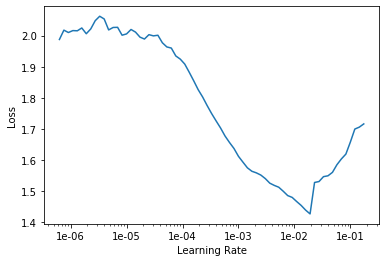

In [19]:
learn.recorder.plot()

### 1a

In [24]:
lr = 2e-4
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

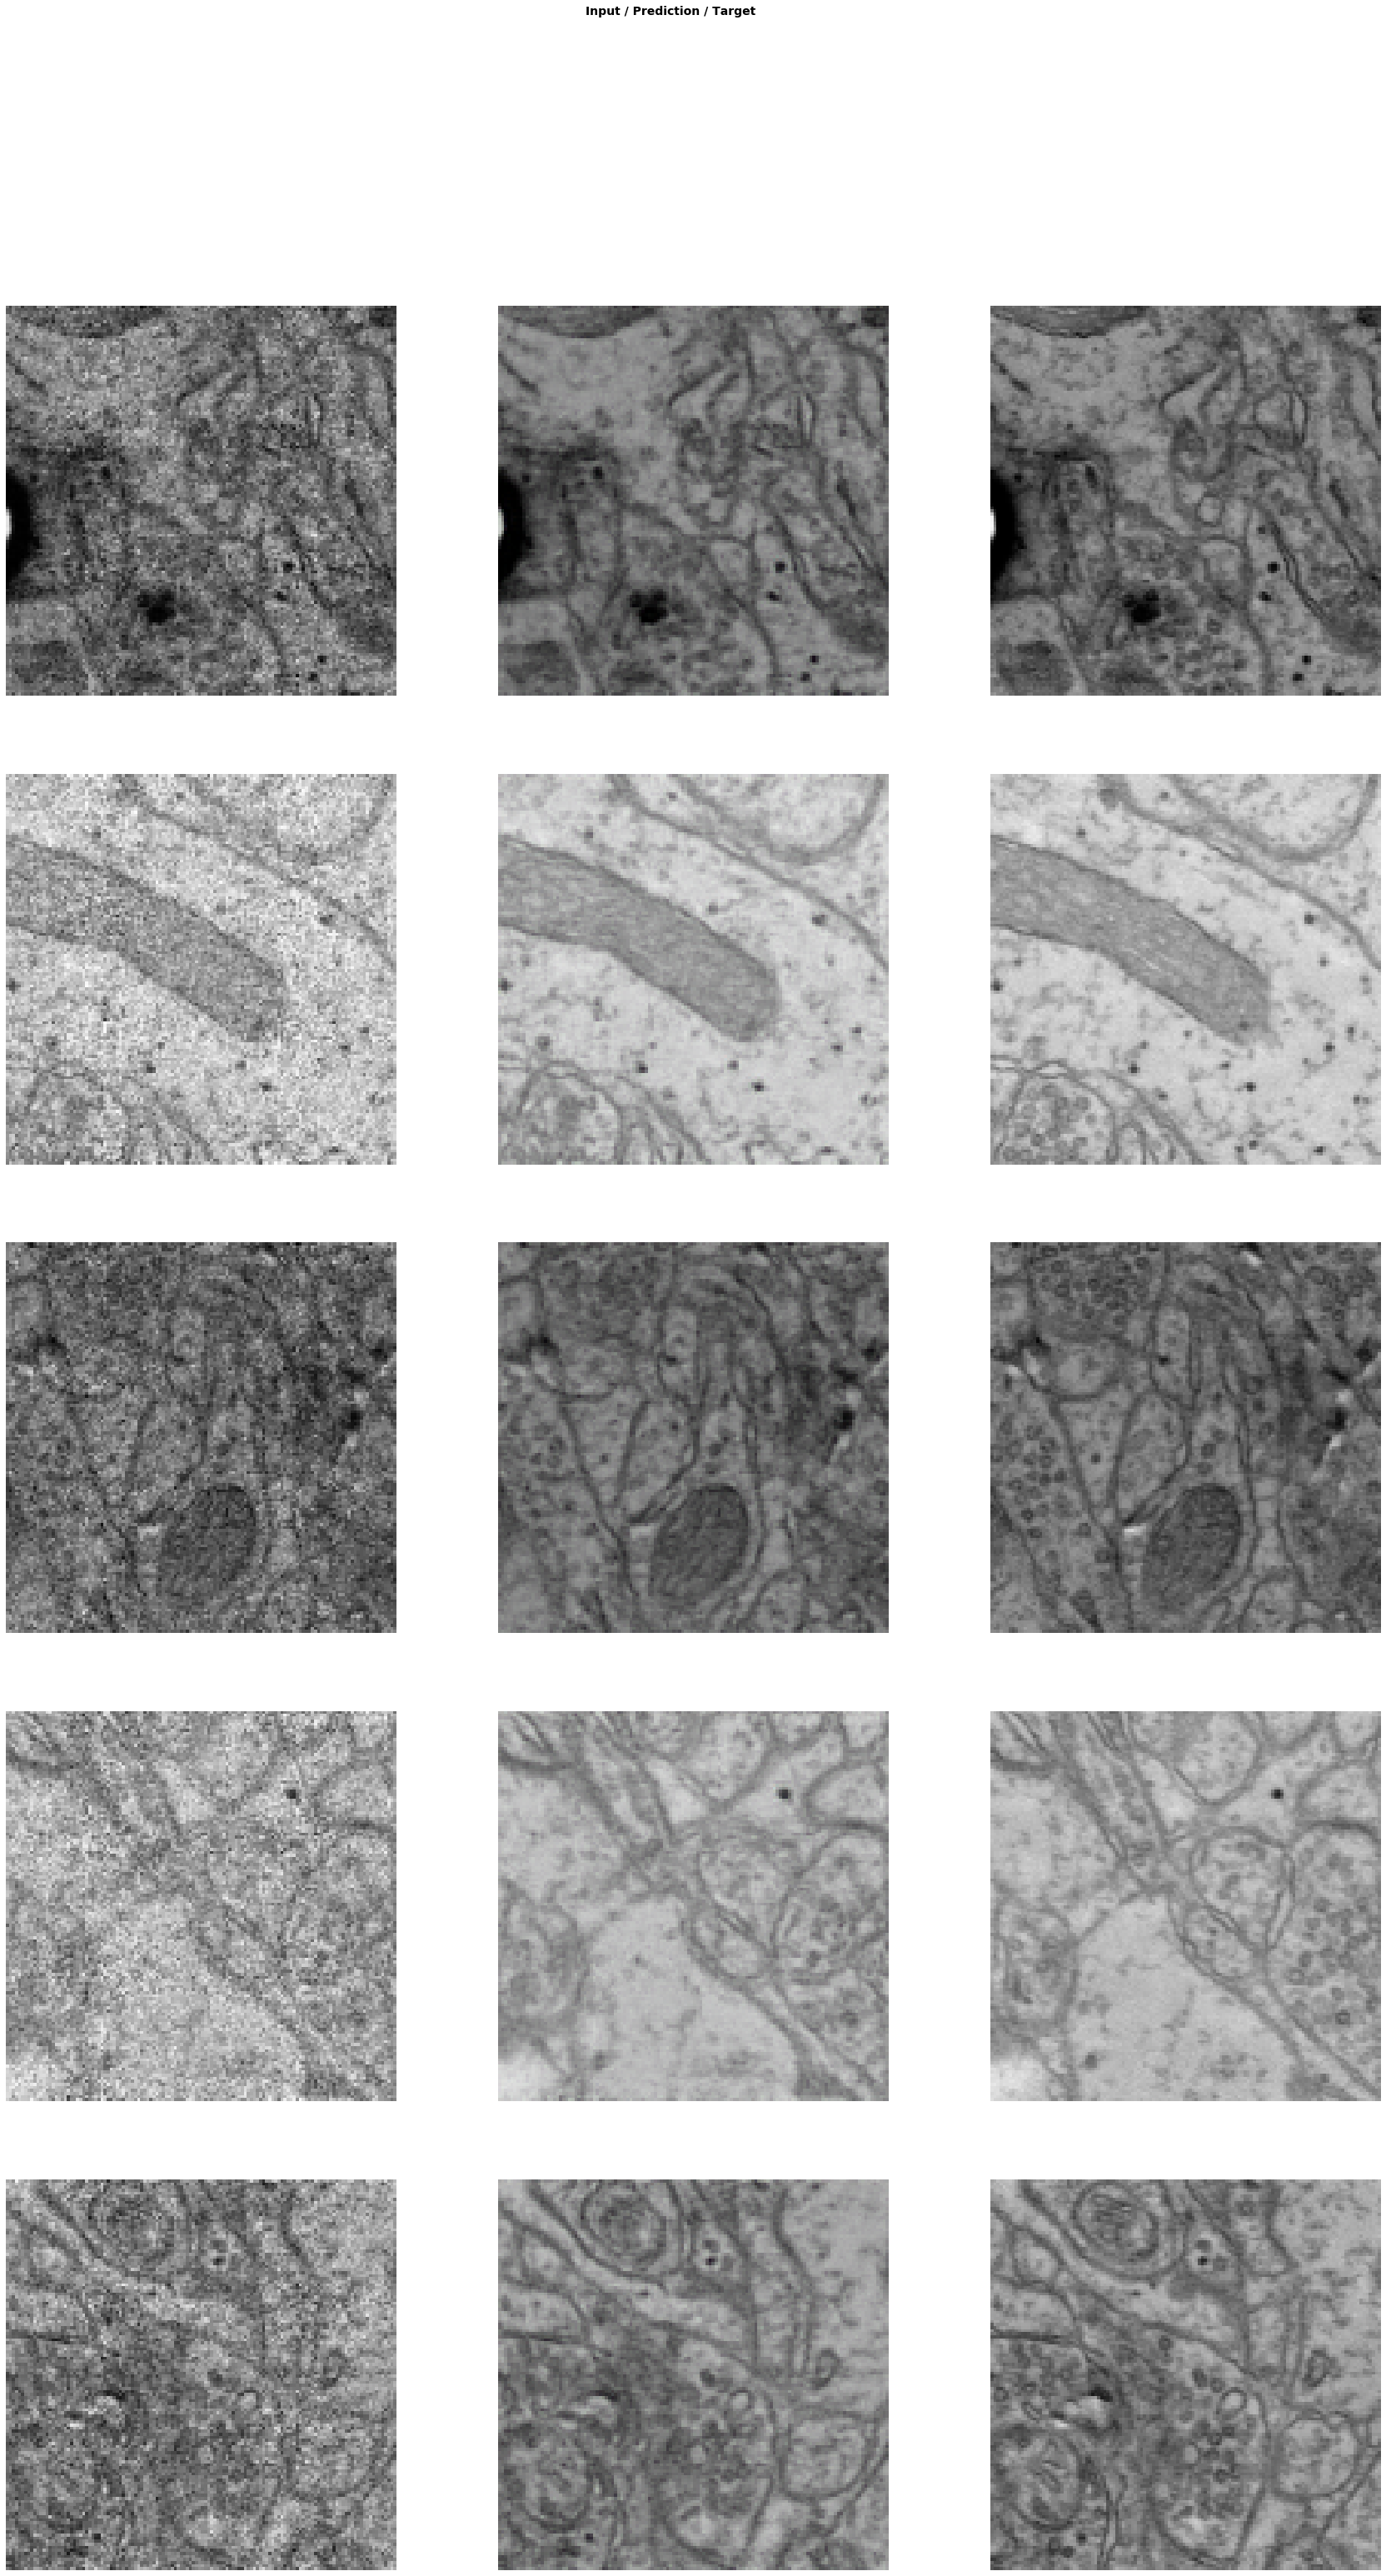

In [25]:
learn.show_results(rows=5, figsize=(30,50))

In [28]:
len(learn.data.valid_dl)

313

### 1b

In [26]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


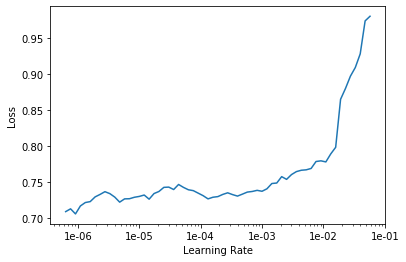

In [35]:
learn.recorder.plot()

In [27]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

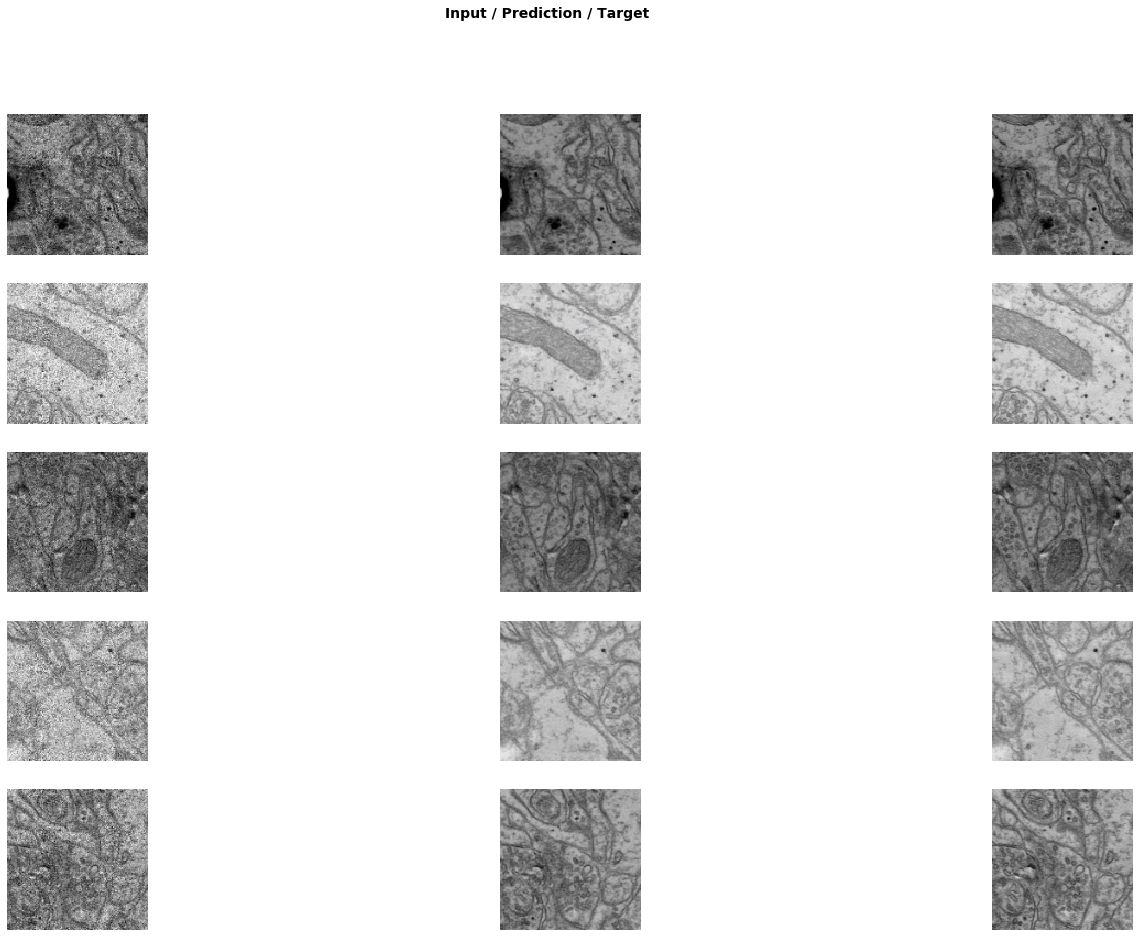

In [28]:
learn.show_results(rows=5, figsize=(25, 15))

## 2a

In [29]:
# loading 3 rounds of data
bs_2 = 32
size_2 = 256
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=3)

In [30]:
learn.data = db

In [31]:
learn.freeze()

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


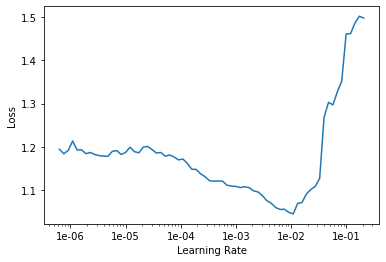

In [46]:
learn.recorder.plot()

In [32]:
lr = 3e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

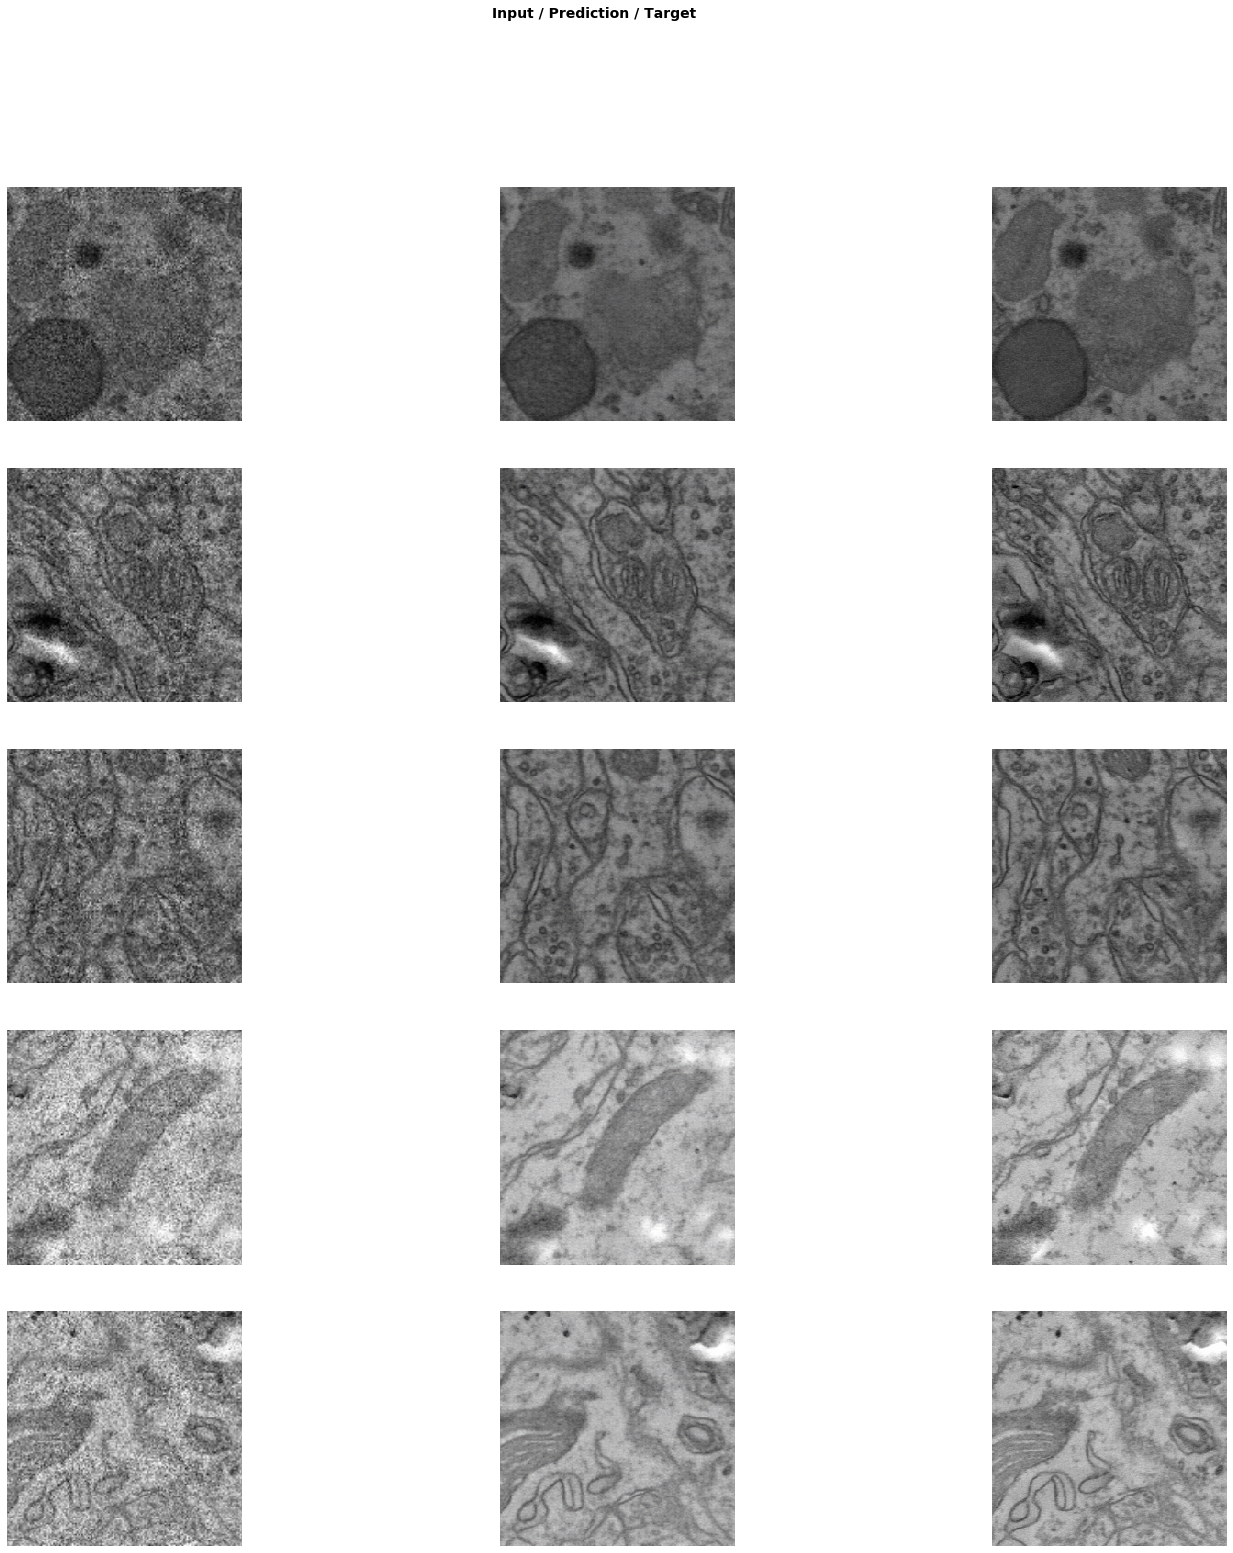

In [33]:
learn.show_results(rows=5, figsize=(25, 25))

## 2b

In [34]:
learn.unfreeze()

In [35]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b', with_opt=False)

In [18]:
learn = learn.load(f'{nb_name}.2b');
learn.validate()

[0.4595427, tensor(0.0450), tensor(21.8443), tensor(0.6406)]

In [20]:
learn.load(f"emsynth_005_unet.5");
learn.validate()

[1.6133391, tensor(0.0591), tensor(20.6605), tensor(0.4628)]

## 3a

In [36]:
# loading 3 rounds of data
bs_3 = 8
size_3 = 512
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_3, in_sz=size_3, out_sz=size_3, max_zoom=2.)

In [37]:
learn.data = db
learn.data

ImageDataBunch;

Train: LabelList (79998 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Valid: LabelList (19999 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/lr;

Test: None

In [38]:
learn.freeze()

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


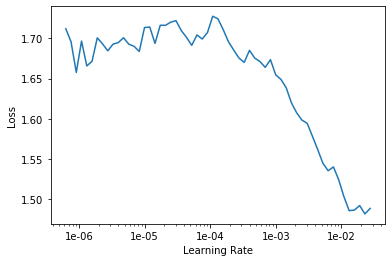

In [28]:
learn.recorder.plot()

In [39]:
lr = 1e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.3a', with_opt=False)

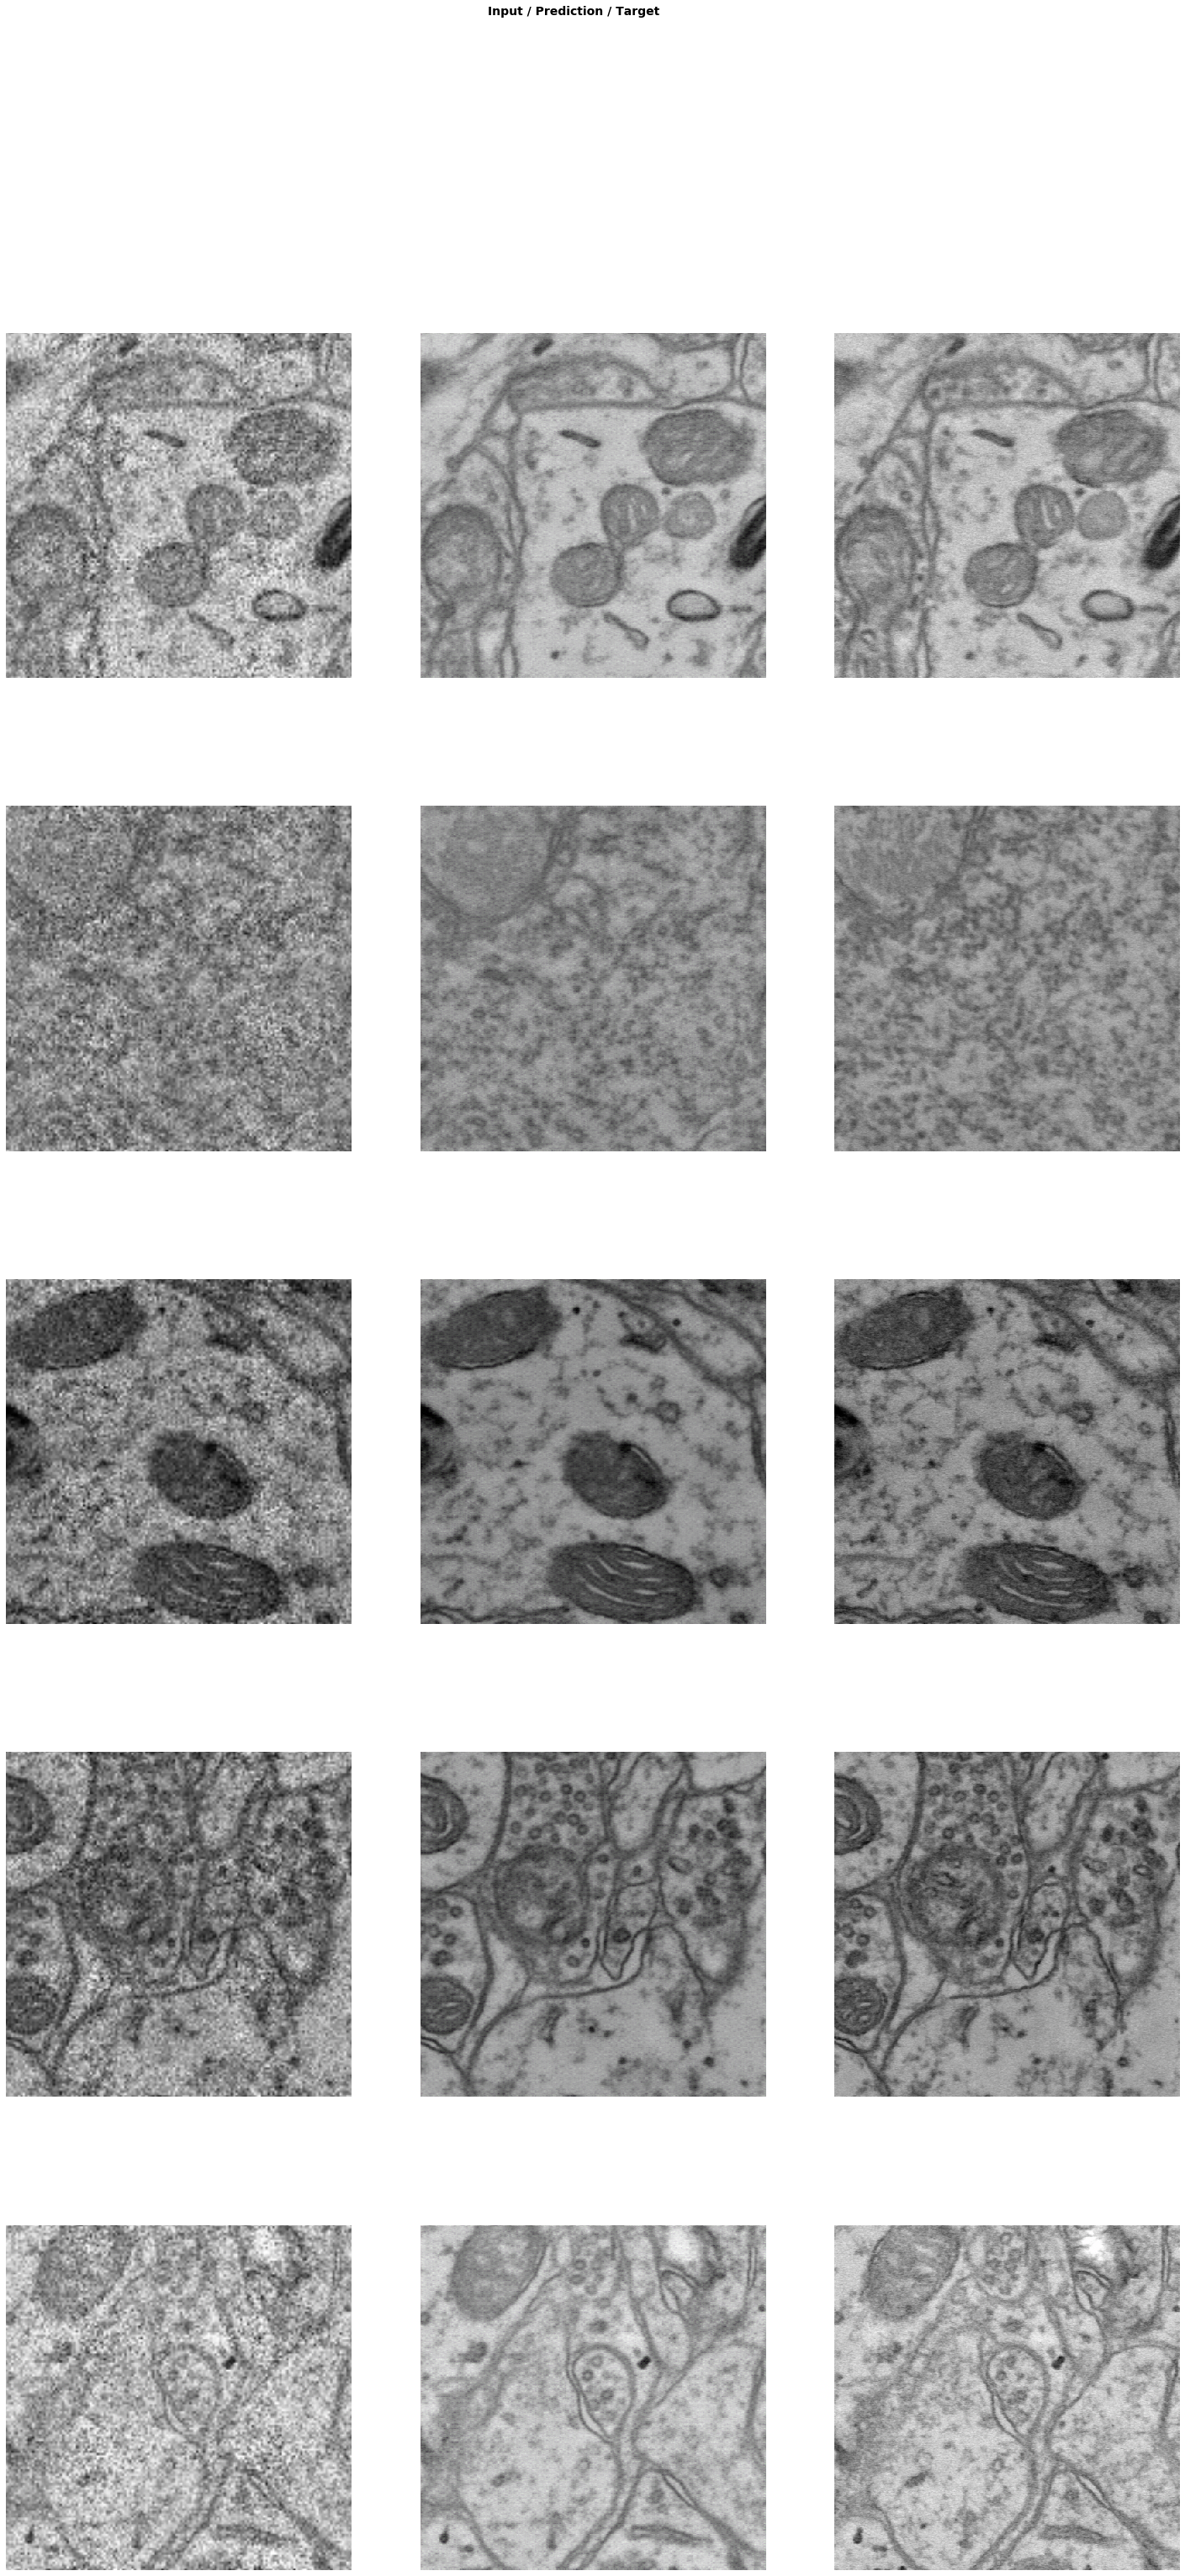

In [40]:
learn.show_results(rows=5, figsize=(25, int(25*2)))

In [41]:
learn.unfreeze()

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


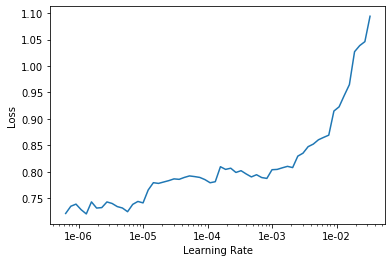

In [36]:
learn.recorder.plot()

In [42]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3b', with_opt=False)

In [ ]:
def patchwise_mse(target, predict, coords):
    num_patches = coords.shape[0]
    for xys in coords:
        loss += mse(predict[xys[0]:xys[1], xys[2]:xys[3]])
    return loss / num_patches